# Решение матричной игры симплекс-методом

In [11]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Проверка на наличие седловой точки
Если седловая точка существует, то возвращаются ее координаты. В таком случае, решение игры выписывается в чистых стратегиях.

In [12]:
def saddle_point(a):
    m = len(a); n = len(a[0])
    min_a = np.zeros(m)
    max_a = np.zeros(n)
    for i in range(m):
        min_a[i] = np.min(a[i])
      
    for j in range(n):
        max_a[j] = np.max(a[:,j])
        
    maxmin = np.max(min_a)
    minmax = np.min(max_a)
    if maxmin == minmax:
        index_max = np.where(min_a == maxmin)[0][0]
        index_min = np.where(max_a == minmax)[0][0]
        return index_max, index_min, a[index_max], a[:,index_min]
    return -1,-1,-1,-1

# Удаление доминируемых строк и столбцов
Говорят, что $i$-я стратегия 1-го игрока доминирует его $k$-ю стратегию, если $a_{ij}$ ≥ $a_{kj}$ для всех $j \in N$ и хотя бы для одного $j$ $a_{ij} > a_{kj}$. В этом случае говорят также, что $i$-я стратегия (или строка) – доминирующая, $k$-я – доминируемая. 

Говорят, что $j$-я стратегия 2-го игрока доминирует его $l$-ю стратегию, если для всех $j \in M$ $a_{ij} ≤ a_{il}$ и хотя бы для одного $i$ $a_{ij} < a_{il}$. В этом случае $j$-ю стратегию (столбец) называют доминирующей, $l$-ю – доминируемой. 

Удаление доминируемых строк и столбцов происходит до тех пор, пока это возможно.

In [13]:
def dominant_strategies(a):
    a_copy = np.copy(a)
    m0 = len(a); n0 = len(a[0])
    rows = np.arange(1,m0+1)
    cols = np.arange(1,n0+1)
    
    while 1:
        m = len(a); n = len(a[0])
        deleted = 0; k=0;l=0
        for i in range(m0):
            if rows[i] == 0 or k >= m:
                continue
            delete = 0
            for j in range(m0):
                if rows[j] == 0 or l >= m:
                    continue
                if k != l:
                    if np.prod(a[k] >= a[l]) == 1:
                        a = np.delete(a, (l), axis=0)
                        rows[j] = 0
                        delete += 1
                        m = len(a)
                        if k >= l:
                            k -= 1
                        l -= 1
                l += 1
            l=0
            k += 1
            deleted += delete
        
        m = len(a); n = len(a[0])
        k=0;l=0
        for i in range(n0):
            if cols[i] == 0 or k >= n:
                continue
            delete = 0
            for j in range(n0):
                if cols[j] == 0 or l >= n:
                    continue
                if k != l:
                    if np.prod(a[:,k] <= a[:,l]) == 1:
                        a = np.delete(a, (l), axis=1)
                        cols[j] = 0
                        delete += 1
                        n = len(a[0])
                        if k >= l:
                            k -= 1
                        l -= 1
                l += 1
            l=0
            k += 1
            deleted += delete
        if deleted == 0:
            break
                    
    if 0 in rows:
        print("Unused pure strategies for the 1st player:")
        for i in range(m0):
            if rows[i] == 0:
                print(a_copy[i])
        print()
            
    if 0 in cols:       
        print("Unused pure strategies for the 2st player:")
        for j in range(n0):
            if cols[j] == 0:
                print(a_copy[:,j])
        print()
    return a, rows, cols

# Создание симплекс-таблицы
На основе исходной матрица $a$, создается симплекс таблица, где первый столбец - столбец свободных переменных, состоящий из $-1$. Самая последняя (индексная) строка состоит из единиц.

In [14]:
def create_s0(a):
    m = len(a); n = len(a[0])
    s0 = np.zeros((n+1,m+2))
    
    for j in range(1,m+1):
        s0[n][j] = 1
    for i in range(n):
        s0[i][0] = -1
        for j in range(1,m+1):
            s0[i][j] = -a[j-1][i]
    return s0

# Реализация алгоритма симплекс-метода
Данный алгоритм повторяется до тех пор, пока в столбце свободных переменных есть отрицательные значения.

In [15]:
def simplex(s0,indices):
    m = len(s0); n = len(s0[0])
    min_el = np.min(s0[:-1,0])
    if min_el >= 0:
        return 1
    
    leading_row = (np.where(s0[:-1,0] == min_el))[0][0]
    
    min_ = leading_col = 1000
    for i in range(1,n-1):
        if s0[leading_row][i] < 0:
            temp = abs(s0[m-1][i] / s0[leading_row][i])
            if temp < min_:
                min_ = temp
                leading_col = i
    leading_el = s0[leading_row][leading_col]            
    index_col = indices[leading_col-1]
    index_row = indices[leading_row + n - 2]
    indices[leading_col - 1] = index_row
    indices[leading_row + n - 2] = index_col
  
    for j in range(n-1):
        s0[leading_row][j] /= leading_el
    s0[leading_row][leading_col] = 1 / leading_el
    
    for i in range(m):
        s0[i][n-1] = - s0[i][leading_col]
    for i in range(m):
        if i == leading_row:
            continue
        for j in range(n-1):
            if j == leading_col:
                s0[i][j] = s0[leading_row][j] * s0[i][n-1]
            else:
                s0[i][j] += s0[leading_row][j] * s0[i][n-1]
    return 0

# Проверка полученного результата
Данная функция проверяет, являются ли найденные смешанные оптимальные стратегии правильными.

In [16]:
def check_result(v,p,q,a,rows,cols):
    m = len(a); n = len(a[0])
    m0 = len(p); n0 = len(q)
    v = round(v,3)
    l=0
    for i in range(n0):
        if cols[i] == 0 or l >= n:
             continue
        sum = 0
        k = 0
        for j in range(m0):
            if rows[j] == 0 or k >= m:
                continue
            sum += p[j]*a[k][l]
            
            k += 1
        l += 1
        if round(sum,3) < v:
            return 0
        
    l=0
    for i in range(m0):
        sum = 0
        if rows[i] == 0 or l >= m:
             continue
        k = 0
        for j in range(n0):
            if cols[j] == 0 or k >= n:
                continue
            sum += q[j]*a[l][k]
            k += 1
        l += 1
        if round(sum,3) > v:
            return 0
    return 1

# Функция nash_equilibrium(a)
Строит симплекс-таблицы. Формирует и возвращает оптимальные стратегии игроков.

In [17]:
def nash_equilibrium(a):
    print("Input:\n",a)
    print()
    m0= len(a); n0 = len(a[0])
    row, column, strategy1, strategy2 = saddle_point(a)
    if isinstance(strategy1, int) == 0:
        print("Equillibrium situation.")
        print("Optimal strategy for the first player: ", strategy1)
        print("Optimal strategy for the second player: ", strategy2)
        return row,column
    a, rows, cols = dominant_strategies(a)
    
    min_el = np.min(a)
    if min_el < 0:
        a += abs(min_el)
    else:
        min_el = 0
        
    s0 = create_s0(a)
    m = len(a); n = len(a[0])
    indices = [i+1 for i in range(m+n)]
    
    sign = 0
    while sign == 0:
        sign = simplex(s0, indices)
        
    x = np.zeros(m); y = np.zeros(n)    
    for i in range(m+n):
        if i < m and indices[i] > m:
            y[indices[i]-m-1] = s0[n][i+1]
        elif i >= m and indices[i] <= n:
            x[indices[i]-1] = s0[i-m][0]
            
    v = 1/np.sum(x)
    
    p = np.zeros(m0); q = np.zeros(n0)
    j = 0
    for i in range(m0):
        if rows[i] == 0:
            continue
        if j >= m:
            break
        p[i] = x[j] * v
        j += 1
        
    j = 0   
    for i in range(n0):
        if cols[i] == 0:
            continue
        if j >= n:
            break
        q[i] = y[j] * v
        j += 1
    
    if check_result(v,p,q,a,rows,cols) == 0:
        print("The game has no solution")
        return -1,-1
    v += min_el
    print("Game price v = ",v)
    print("Optimal strategy for the first player:\n ", p)
    print("Optimal strategy for the second player:\n ", q)
    return np.array(p),np.array(q)

# Считывание матриц с файла


In [18]:
def read_matrix(file):
    return np.loadtxt(file, dtype='f', delimiter=' ')

# Функция nash(), которая запускает программу
Здесь считывается матрица из файла, вызывается функция nash_equilibrium и строится график для спектров оптимальных стратегий.

In [22]:
def nash():
    path = os.path.join('.','matrices', 'matrix_equilibrium.txt')
    if len(sys.argv) > 3:
        path = sys.argv[1]
    
    a = read_matrix(path)
    p,q = nash_equilibrium(a)
    try:
        i = 0   
        x = [i+1 for i in range(len(p))]
        i = 0
        y1 = [0 for i in range(len(p))]
    except TypeError:
        if p == q == -1:
            sys.exit()
        x = p + 1
        p = q + 1
        y1 = 0
    
    plt.vlines(x, ymin=y1, ymax=p, color='blue')
    plt.scatter(x, p, s=10, color='blue')
    plt.show()

Input:
 [[ 5.  7. 10.  8.]
 [10.  9. 11. 10.]
 [ 8.  6.  7.  4.]]

Equillibrium situation.
Optimal strategy for the first player:  [10.  9. 11. 10.]
Optimal strategy for the second player:  [7. 9. 6.]


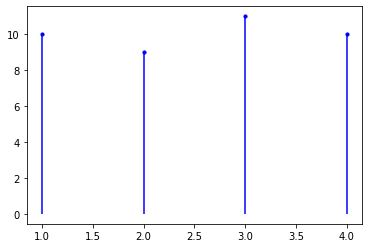

In [23]:
nash()